In [2]:
import numpy as np
from scipy.interpolate import interp1d
from simpegem1d import EM1DAnalytics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
def v_step_exp(t, tau=0.001):
    return 1./tau * np.exp(-t/tau)
def v_ramp_off_exp(t, t0, tau=0.001):
    return 1./t0 * (- np.exp(-(t+t0)/tau) + np.exp(-(t)/tau))

In [33]:
def v_step_e(t):
    return 1./t
def v_ramp_off_e(t, t0):
    return 1./t0 * np.log((t+t0)/t)

In [34]:
def v_step_l(t):
    return t**(-5./2)
def v_ramp_off_l(t, t0):
    F_t_t0 = 2*t * (1-(1+t0/t)**-1.5) / (3*t0)
    return t**(-5./2) * F_t_t0
def v_step(time):
    return EM1DAnalytics.dBzdtAnalCircT(
    10., time, 1e-1
    )

In [35]:
from scipy.integrate import fixed_quad, quadrature
t0 = 1e-3

In [36]:
time = np.logspace(-4, -2, 21)

In [37]:
%%time
output_fixed_exp = np.array([fixed_quad(v_step_exp, t, t+t0)[0] for t in time])
output_fixed_e = np.array([fixed_quad(v_step_e, t, t+t0)[0] for t in time])
output_fixed_l = np.array([fixed_quad(v_step_l, t, t+t0)[0] for t in time])

CPU times: user 1.24 ms, sys: 283 µs, total: 1.52 ms
Wall time: 1.55 ms


In [38]:
%%time
output_exp = np.array([quadrature(v_step_exp, t, t+t0)[0] for t in time])
output_e = np.array([quadrature(v_step_e, t, t+t0)[0] for t in time])
output_l = np.array([quadrature(v_step_l, t, t+t0)[0] for t in time])

CPU times: user 16.9 ms, sys: 1.89 ms, total: 18.8 ms
Wall time: 18.8 ms


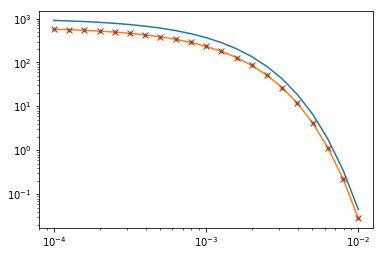

In [39]:
plt.loglog(time, v_step_exp(time))
plt.loglog(time, v_ramp_off_exp(time, 1e-3))
plt.loglog(time, output_exp/t0, '.')
plt.loglog(time, output_fixed_exp/t0, 'x')

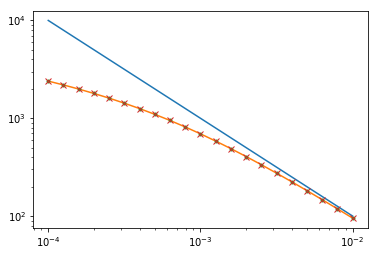

In [40]:
plt.loglog(time, v_step_e(time))
plt.loglog(time, v_ramp_off_e(time, 1e-3))
plt.loglog(time, output_e/t0, '.')
plt.loglog(time, output_fixed_e/t0, 'x')

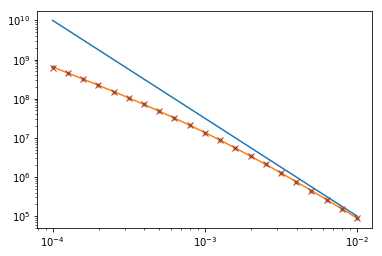

In [41]:
plt.loglog(time, v_step_l(time))
plt.loglog(time, v_ramp_off_l(time, 1e-3))
plt.loglog(time, output_l/t0, '.')
plt.loglog(time, output_fixed_l/t0, 'x')

In [42]:
from simpegem1d import skytem_HM_2015
wave = skytem_HM_2015()

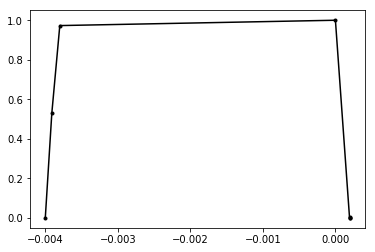

In [43]:
plt.plot(wave.current_times[-7:], wave.currents[-7:], 'k.-')

In [44]:
wave.current_times[-7:].max() * 1e3

0.196368

In [45]:
t0s = np.diff(wave.currents[-7:]) / np.diff(wave.current_times[-7:])
Tp = wave.current_times[-7:].max()-wave.current_times[-7:].min()

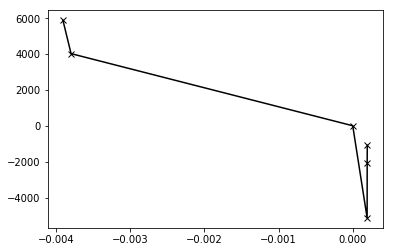

In [46]:
plt.plot(wave.current_times[-7:][1:], t0s, 'kx-')

In [47]:
from scipy.integrate import fixed_quad
step_func = v_step_exp
# T = 1./25.
t_off = np.logspace(-5, -2, 31)
t_currents = np.r_[0., 0.002, 0.004]
T = t_currents.max()
currents = np.r_[0., 1., 0.]

def piecewise_ramp(step_func, t_off, t_currents, currents, n=20, eps=1e-10):
    """
    Computes response from piecewise linear current waveform with a single pulse.
    This basically evaluates the convolution between dI/dt and step-off response.
    
    step_func: function handle to evaluate step-off response
    t_off: time channels when the current is off
    currents: input source currents
    n: Gaussian quadrature order
    """
    dt = np.diff(t_currents)
    dI = np.diff(currents)
    dIdt = dI/dt
    nt = t_currents.size
    response = np.zeros(t_off.size, dtype=float)
    pulse_time = t_currents.max()
    
    for i in range(1, nt):
        t_lag = pulse_time - t_currents[i]
        time = t_lag + t_off
        t0 = dt[i-1]
        const = -dIdt[i-1]
        if abs(const) > eps:
            response += np.array([fixed_quad(step_func, t, t+t0, n=20)[0] for t in time]) * const        
    return response

def double_pulse(step_func, t_off, t_currents, currents, T, n=20):
    """
    Computes response from double pulses (negative then positive)
    T: Period (e.g. 25 Hz base frequency, 0.04 s period)    
    """
    response_double = (
        piecewise_ramp(step_func, t_off, t_currents, currents, n=n)
        -piecewise_ramp(step_func, t_off+T/2., t_currents, currents, n=n) * 0.5
    )
    return response_double

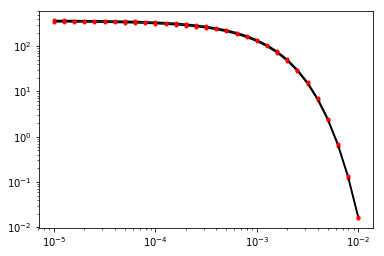

In [48]:
# single pulse
response_single = piecewise_ramp(v_step_exp, t_off, t_currents, currents)
response_single_true = v_ramp_off_exp(t_off, 2e-3)-v_ramp_off_exp(t_off+0.002, 2e-3)
# double pulse
response_double = double_pulse(v_step_exp, t_off, t_currents, currents, T)

response_double_true = (
    v_ramp_off_exp(t_off, 2e-3)-v_ramp_off_exp(t_off+0.002, 2e-3)+
    -(v_ramp_off_exp(t_off+T/2., 2e-3)-v_ramp_off_exp(t_off+0.002+T/2, 2e-3)) * 0.5
)
plt.loglog(t_off, response_double, 'k')
plt.loglog(t_off, response_double_true, 'r.')

plt.loglog(t_off, response_single, 'k')
plt.loglog(t_off, response_single_true, 'r.')

In [49]:
%%time
response_single = piecewise_ramp(v_step_l, t_off, t_currents, currents)

CPU times: user 1.57 ms, sys: 36 µs, total: 1.61 ms
Wall time: 1.62 ms


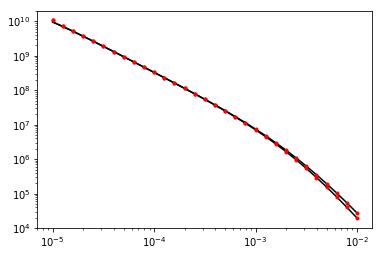

In [50]:
# single pulse
response_single = piecewise_ramp(v_step_l, t_off, t_currents, currents)
response_single_true = v_ramp_off_l(t_off, 2e-3)-v_ramp_off_l(t_off+0.002, 2e-3)
# double pulse
response_double = double_pulse(v_step_l, t_off, t_currents, currents, T)
response_double_true = (
    v_ramp_off_l(t_off, 2e-3)-v_ramp_off_l(t_off+0.002, 2e-3)+
    -(v_ramp_off_l(t_off+T/2., 2e-3)-v_ramp_off_l(t_off+0.002+T/2, 2e-3)) * 0.5
)
plt.loglog(t_off, response_double, 'k')
plt.loglog(t_off, response_double_true, 'r.')

plt.loglog(t_off, response_single, 'k')
plt.loglog(t_off, response_single_true, 'r.')

In [51]:
%%time
response_single_true = piecewise_ramp(v_step, t_off, t_currents, currents, n=5)

CPU times: user 2.49 ms, sys: 45 µs, total: 2.54 ms
Wall time: 2.54 ms


In [52]:
%%time
response_single_true = piecewise_ramp(v_step, t_off, t_currents, currents, n=20)

CPU times: user 2.97 ms, sys: 29 µs, total: 3 ms
Wall time: 3.01 ms


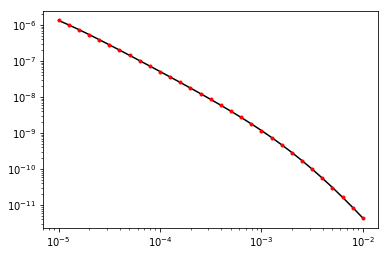

In [53]:
# single pulse
response_single = piecewise_ramp(v_step, t_off, t_currents, currents, n=20)

plt.loglog(t_off, -response_single, 'k')
plt.loglog(t_off, -response_single_true, 'r.')

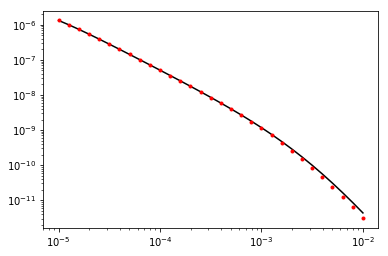

In [54]:
# single pulse
response_single = piecewise_ramp(v_step, t_off, t_currents, currents, n=20)
response_double = double_pulse(v_step, t_off, t_currents, currents, T)
plt.loglog(t_off, -response_single, 'k')
plt.loglog(t_off, -response_double, 'r.')